In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import statistics
from random import uniform, seed
from math import sqrt
from dataclasses import dataclass

In [97]:
@dataclass
class Agent:
    AgentID: int
    Color: str 
    Happy: int 
    x_loc: float
    y_loc: float
    neighbors: []

In [98]:
def findNeighborDistances(Agent_Array):
    for i in range(0, len(Agent_Array)):
        Agent_Array[i].neighbors.clear()
        for j in range(0, len(Agent_Array)):
            Agent_Array[i].neighbors.append((Agent_Array[j].AgentID, sqrt((Agent_Array[i].x_loc-Agent_Array[j].x_loc)**2+(Agent_Array[i].y_loc-Agent_Array[j].y_loc)**2)))

In [99]:
def assignHappiness(Agent_Array, bias, k, plots):
    homogeneity_vec = []
    for i in range(0, len(Agent_Array)):
        closestNeighbors = sorted(Agent_Array[i].neighbors, key = lambda x: x[1])[1:(k+1)]
        matchedNeighbors = 0
        AgentColor = Agent_Array[i].Color
        for j in range(0, len(closestNeighbors)):
            neighborID = closestNeighbors[j][0]
            for Agent in Agent_Array:
                if Agent.AgentID == neighborID:
                    if Agent.Color==AgentColor:
                        matchedNeighbors = matchedNeighbors + 1
        homogeneity_vec.append(matchedNeighbors/k)
        if(matchedNeighbors/k >= bias):
            Agent_Array[i].Happy = 1
        else:
            Agent_Array[i].Happy = 0
    if(plots == True):
        print("Mean homogeneity: ", statistics.mean(homogeneity_vec), "% \n")
    return statistics.mean(homogeneity_vec)

In [100]:
def decideWhoMoves(Agent_Array, Agent_Grid):
    N = len(Agent_Array)
    for i in range(0, N):
        if(Agent_Array[i].Happy == 0):
            x_rand = np.random.choice(np.arange(40), 1)[0]
            y_rand = np.random.choice(np.arange(40), 1)[0]
            while(Agent_Grid[x_rand, y_rand] != -1):
                x_rand = np.random.choice(np.arange(40), 1)[0]
                y_rand = np.random.choice(np.arange(40), 1)[0]
            Agent_Array[i].x_loc=x_rand
            Agent_Array[i].y_loc=y_rand

In [101]:
def plotNeighborhood(Agent_Array):
    df = pd.DataFrame( columns=['x_loc', 'y_loc', 'color'])
    i=0
    for Agent in Agent_Array:
        df.loc[i] = [Agent.x_loc, Agent.y_loc, Agent.Color]
        i = i+1
    plt.scatter(df["x_loc"], df["y_loc"], c = df["color"])
    plt.show()

In [102]:
def checkHappiness(Agent_Array, plots):
    NumHappy = 0
    for Agent in Agent_Array:
        if Agent.Happy == 1:
            NumHappy = NumHappy+1
    if(plots == True):
        print("Percent of happy agents: ", 100*NumHappy/len(Agent_Array), "% \n")
    return 100*NumHappy/len(Agent_Array)

In [103]:
def runSim(Agent_Array, Agent_Grid, steps, bias, k, plots):
    if(plots == True):
        print("Iteration 0: \n")
        plotNeighborhood(Agent_Array)
    percHappyVec = []
    meanHomogeneousVec = []
    for i in range(0, steps):
        findNeighborDistances(Agent_Array)
        meanHomogeneity = assignHappiness(Agent_Array, bias, k, plots)
        meanHomogeneousVec.append(meanHomogeneity)
        decideWhoMoves(Agent_Array, Agent_Grid)
        if(plots == True):
            print("Iteration ", i+1, " : \n")
        percHappy = checkHappiness(Agent_Array, plots)
        percHappyVec.append(percHappy)
        if(plots == True):
            plotNeighborhood(Agent_Array)
            #print("Percent happy at iteration ", i, ": ", percHappy, "\n")
    return percHappyVec, meanHomogeneousVec

In [104]:
def runSimFullData(Agent_Array, Agent_Grid, steps, bias, k, plots):
    if(plots == True):
        print("Iteration 0: \n")
        plotNeighborhood(Agent_Array)
    fullSimVec = []
    for i in range(0, steps):
        findNeighborDistances(Agent_Array)
        assignHappiness(Agent_Array, bias, k)
        decideWhoMoves(Agent_Array, Agent_Grid)
        if(plots == True):
            print("Iteration ", i+1, " : \n")
        df = pd.DataFrame( columns=['x_loc', 'y_loc', 'color'])
        i=0
        for Agent in Agent_Array:
            df.loc[i] = [Agent.x_loc, Agent.y_loc, Agent.Color]
            i = i+1
        df_green = df[df["color"] == "green"]
        df_orange = df[df["color"] == "orange"]
        df_matrix_green = np.zeros((40, 40))
        df_matrix_orange = np.zeros((40, 40))
        for index, row in df_green.iterrows():
            df_matrix_green[row['x_loc'], row['y_loc']] = 1
        for index, row in df_orange.iterrows():
            df_matrix_orange[row['x_loc'], row['y_loc']] = 1
        vec_green = df_matrix_green.flatten()
        vec_orange = df_matrix_orange.flatten()
        vec_one_hot = np.concatenate((vec_green, vec_orange), axis=None)
        fullSimVec = np.concatenate((fullSimVec, vec_one_hot), axis=None)
        if(plots == True):
            plotNeighborhood(Agent_Array)
    return fullSimVec

In [105]:
def setupAndRunSim(steps, bias, k, orangeNum, greenNum, plots):
    Agent_Array = []
    Agent_Grid = np.ones((40,40))
    Agent_Grid = -1*Agent_Grid
    for i in range(0, orangeNum):
        x_rand = np.random.choice(np.arange(40), 1)[0]
        y_rand = np.random.choice(np.arange(40), 1)[0]
        while(Agent_Grid[x_rand, y_rand] != -1):
            x_rand = np.random.choice(np.arange(40), 1)[0]
            y_rand = np.random.choice(np.arange(40), 1)[0]
        Agent_Grid[x_rand][y_rand] = i
        Agent_Array.append(Agent(AgentID=i, Color="orange", Happy=0, x_loc=x_rand, y_loc=y_rand, neighbors=[]))
    for i in range(0, greenNum):
        x_rand = np.random.choice(np.arange(40), 1)[0]
        y_rand = np.random.choice(np.arange(40), 1)[0]
        while(Agent_Grid[x_rand, y_rand] != -1):
            x_rand = np.random.choice(np.arange(40), 1)[0]
            y_rand = np.random.choice(np.arange(40), 1)[0]
        Agent_Grid[x_rand, y_rand] = i
        Agent_Array.append(Agent(AgentID=i+250, Color="green", Happy=0, x_loc=x_rand, y_loc=y_rand, neighbors=[]))
    finalPercHappyVec, finalPercHomoVec = runSim(Agent_Array, Agent_Grid, steps, bias, k, plots)
    return finalPercHappyVec, finalPercHomoVec

In [106]:
def setupAndRunSimFullOutput(steps, bias, k, orangeNum, greenNum, plots):
    Agent_Array = []
    Agent_Grid = np.ones((40,40))
    Agent_Grid = -1*Agent_Grid
    for i in range(0, orangeNum):
        x_rand = np.random.choice(np.arange(40), 1)[0]
        y_rand = np.random.choice(np.arange(40), 1)[0]
        while(Agent_Grid[x_rand, y_rand] != -1):
            x_rand = np.random.choice(np.arange(40), 1)[0]
            y_rand = np.random.choice(np.arange(40), 1)[0]
        Agent_Grid[x_rand][y_rand] = i
        Agent_Array.append(Agent(AgentID=i, Color="orange", Happy=0, x_loc=x_rand, y_loc=y_rand, neighbors=[]))
    for i in range(0, greenNum):
        x_rand = np.random.choice(np.arange(40), 1)[0]
        y_rand = np.random.choice(np.arange(40), 1)[0]
        while(Agent_Grid[x_rand, y_rand] != -1):
            x_rand = np.random.choice(np.arange(40), 1)[0]
            y_rand = np.random.choice(np.arange(40), 1)[0]
        Agent_Grid[x_rand, y_rand] = i
        Agent_Array.append(Agent(AgentID=i+250, Color="green", Happy=0, x_loc=x_rand, y_loc=y_rand, neighbors=[]))
    fullSimVec = runSimFullData(Agent_Array, Agent_Grid, steps, bias, k, plots)
    return fullSimVec

Iteration 0: 



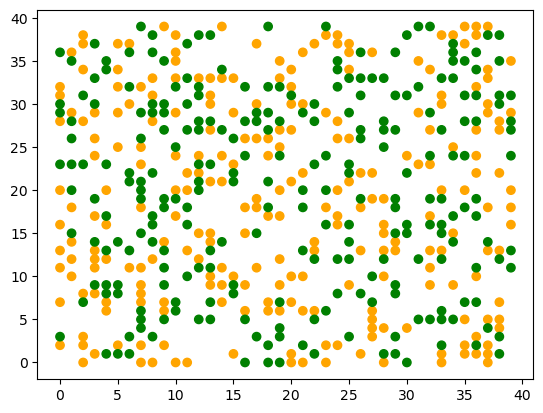

Mean homogeneity:  0.49417670682730924 % 

Iteration  1  : 

Percent of happy agents:  95.18072289156626 % 



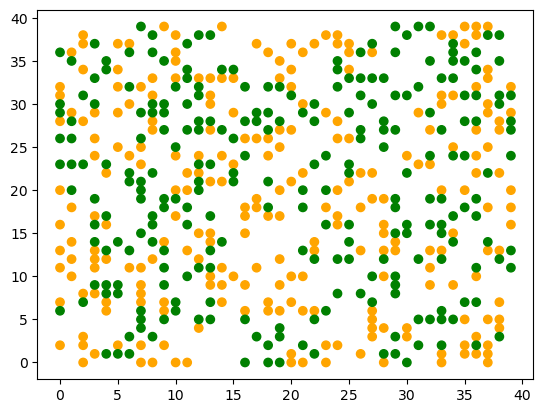

Mean homogeneity:  0.5267068273092369 % 

Iteration  2  : 

Percent of happy agents:  98.39357429718875 % 



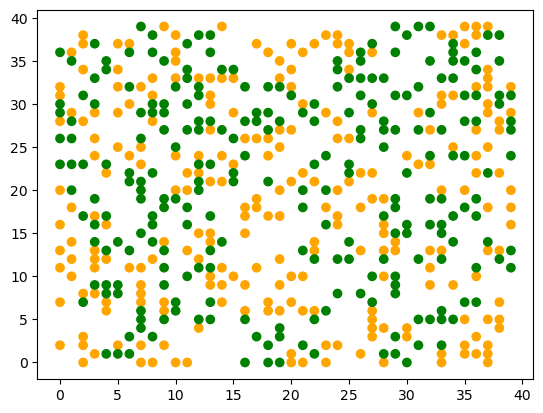

Mean homogeneity:  0.5355421686746988 % 

Iteration  3  : 

Percent of happy agents:  98.99598393574297 % 



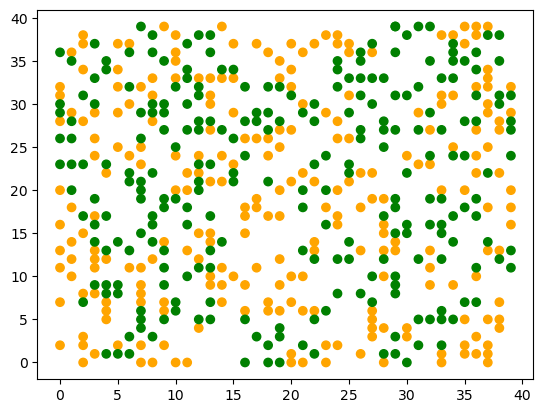

Mean homogeneity:  0.542570281124498 % 

Iteration  4  : 

Percent of happy agents:  99.59839357429719 % 



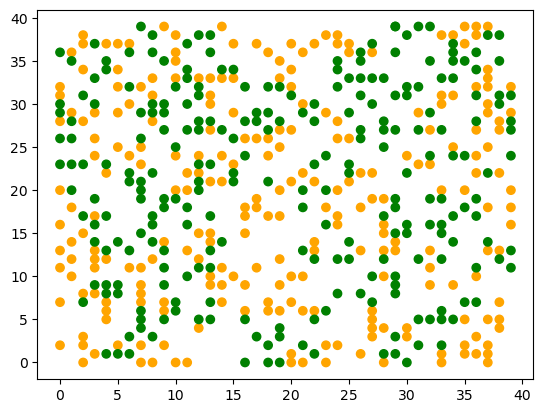

Mean homogeneity:  0.5449799196787148 % 

Iteration  5  : 

Percent of happy agents:  100.0 % 



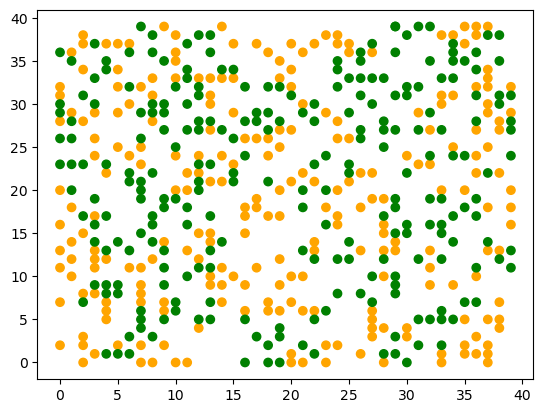

Mean homogeneity:  0.5449799196787148 % 

Iteration  6  : 

Percent of happy agents:  100.0 % 



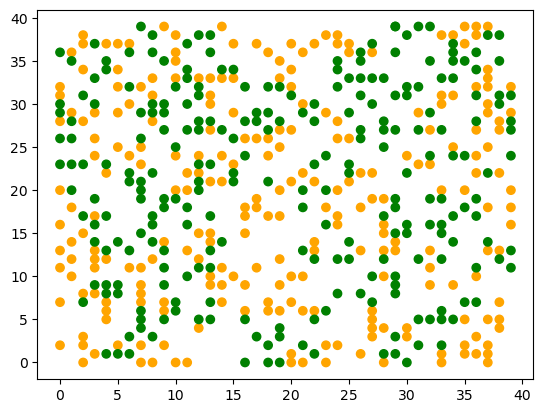

Mean homogeneity:  0.5449799196787148 % 

Iteration  7  : 

Percent of happy agents:  100.0 % 



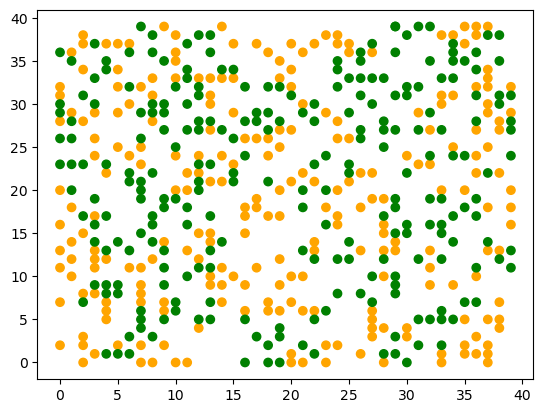

Mean homogeneity:  0.5449799196787148 % 

Iteration  8  : 

Percent of happy agents:  100.0 % 



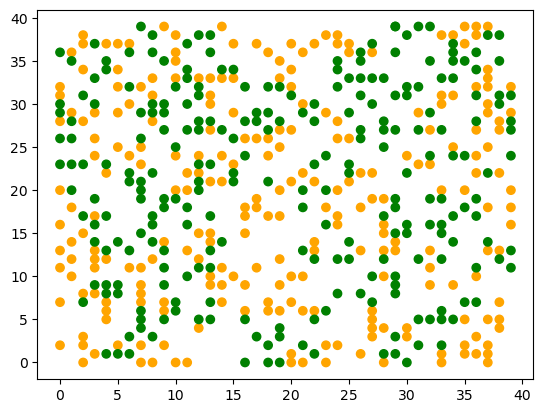

Mean homogeneity:  0.5449799196787148 % 

Iteration  9  : 

Percent of happy agents:  100.0 % 



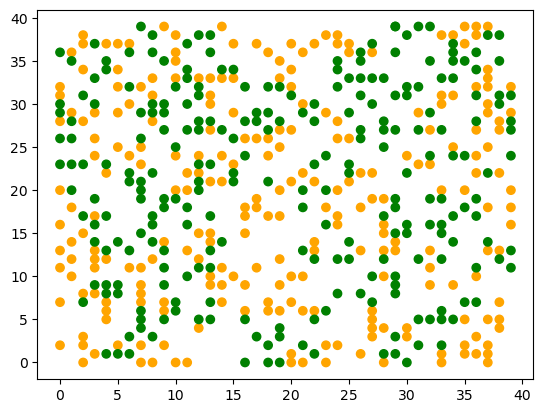

Mean homogeneity:  0.5449799196787148 % 

Iteration  10  : 

Percent of happy agents:  100.0 % 



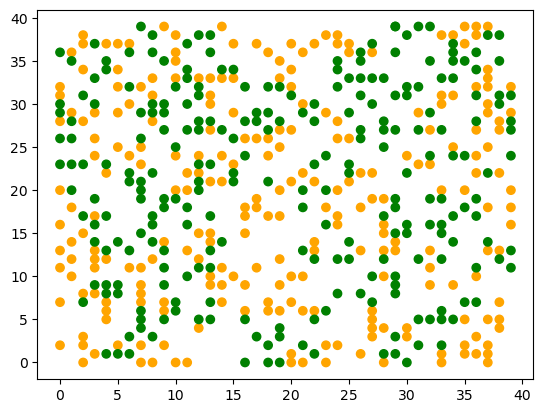

In [107]:
vec = setupAndRunSim(10, 0.30, 10, 249, 249, True)

Iteration 0: 



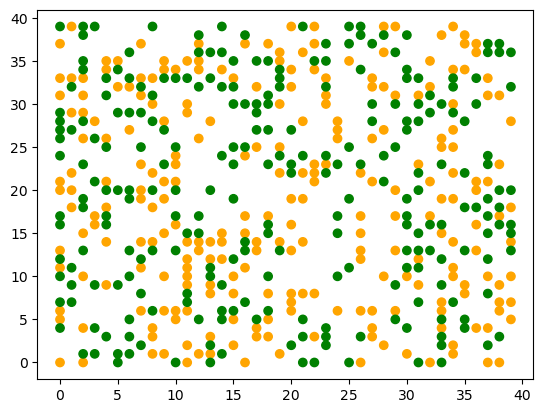

Mean homogeneity:  0.4919678714859438 % 

Iteration  1  : 

Percent of happy agents:  61.04417670682731 % 



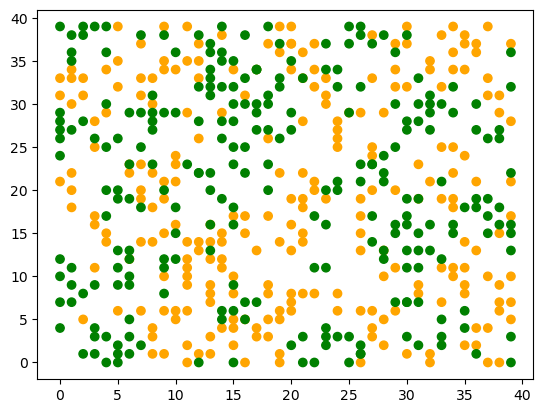

Mean homogeneity:  0.6026104417670682 % 

Iteration  2  : 

Percent of happy agents:  76.70682730923694 % 



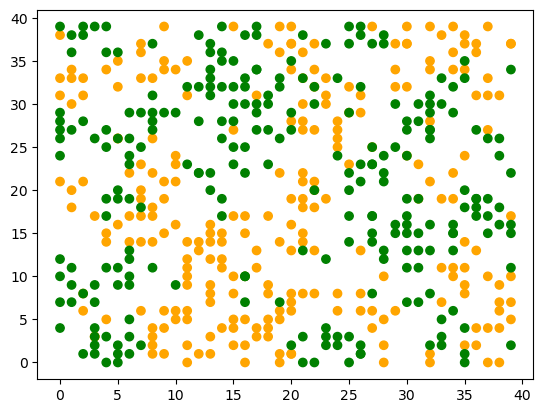

Mean homogeneity:  0.6853413654618474 % 

Iteration  3  : 

Percent of happy agents:  84.73895582329317 % 



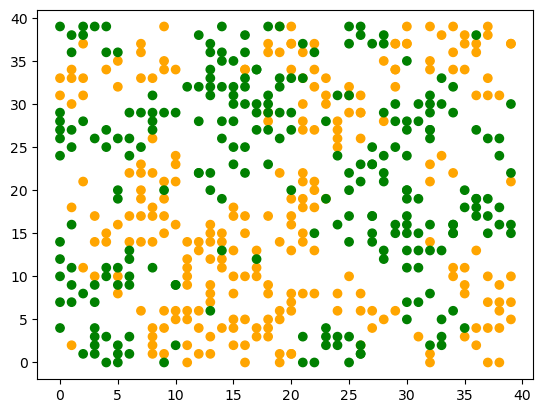

Mean homogeneity:  0.7299196787148594 % 

Iteration  4  : 

Percent of happy agents:  87.95180722891567 % 



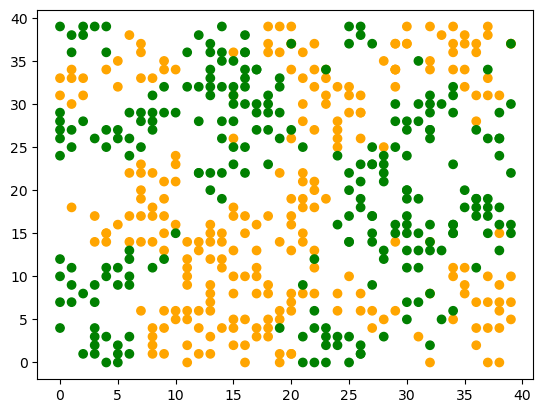

Mean homogeneity:  0.8004016064257028 % 

Iteration  5  : 

Percent of happy agents:  92.36947791164658 % 



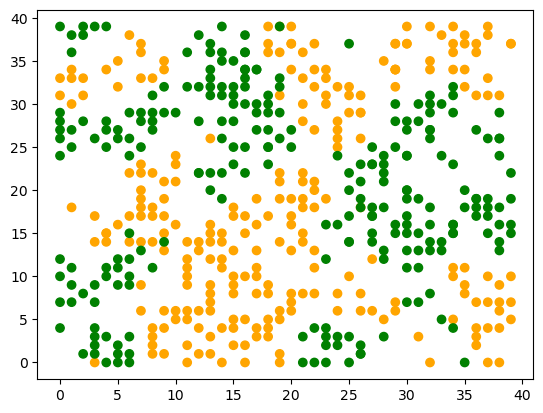

Mean homogeneity:  0.8495983935742972 % 

Iteration  6  : 

Percent of happy agents:  96.3855421686747 % 



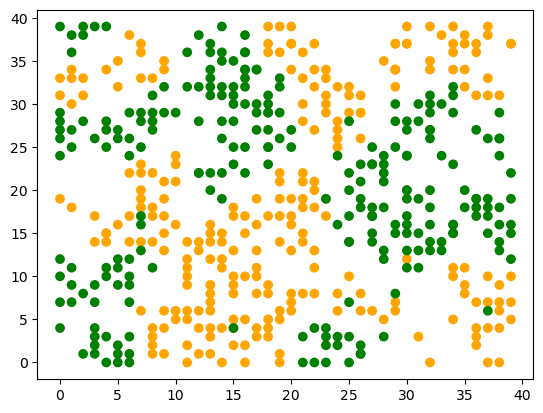

Mean homogeneity:  0.8646586345381526 % 

Iteration  7  : 

Percent of happy agents:  98.19277108433735 % 



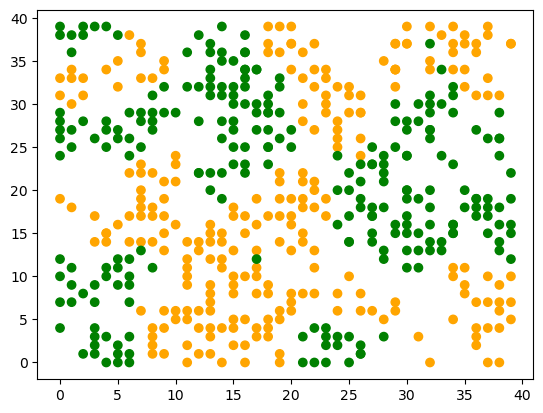

Mean homogeneity:  0.8823293172690763 % 

Iteration  8  : 

Percent of happy agents:  98.99598393574297 % 



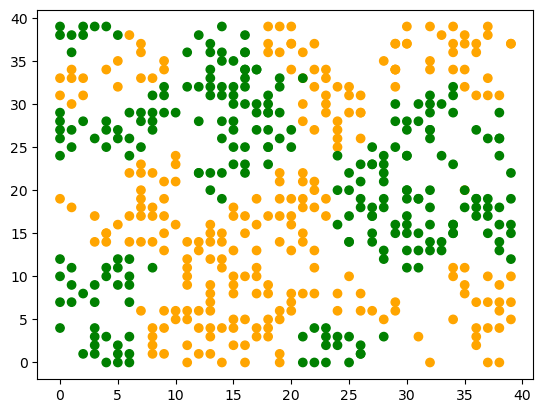

Mean homogeneity:  0.8893574297188755 % 

Iteration  9  : 

Percent of happy agents:  99.39759036144578 % 



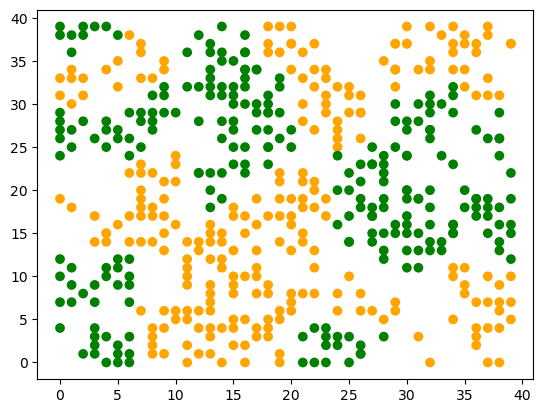

Mean homogeneity:  0.8951807228915662 % 

Iteration  10  : 

Percent of happy agents:  99.79919678714859 % 



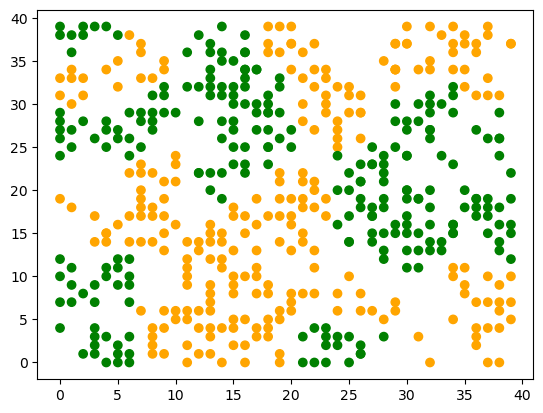

In [79]:
vec = setupAndRunSim(10, 0.50, 10, 249, 249, True)

Iteration 0: 



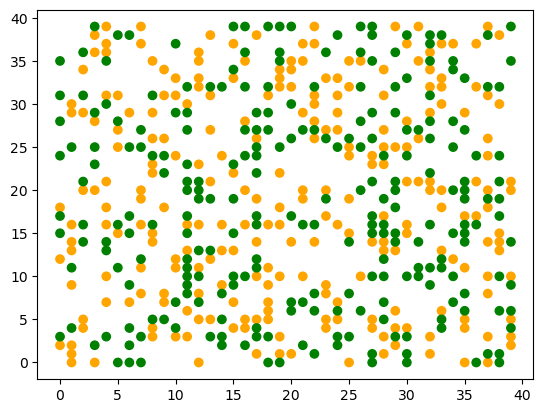

Mean homogeneity:  0.48614457831325303 % 

Iteration  1  : 

Percent of happy agents:  3.0120481927710845 % 



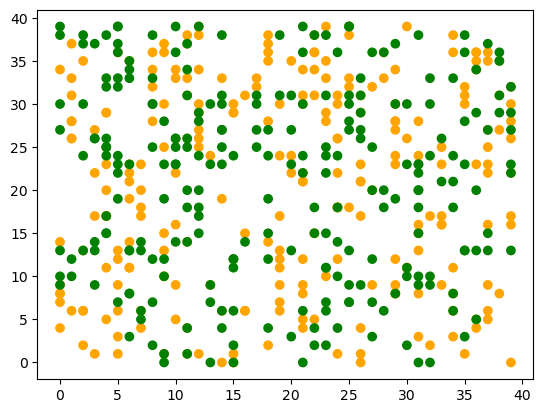

Mean homogeneity:  0.5132530120481927 % 

Iteration  2  : 

Percent of happy agents:  7.028112449799197 % 



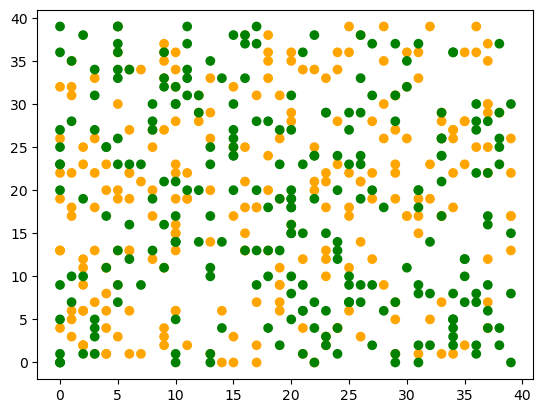

Mean homogeneity:  0.514859437751004 % 

Iteration  3  : 

Percent of happy agents:  7.228915662650603 % 



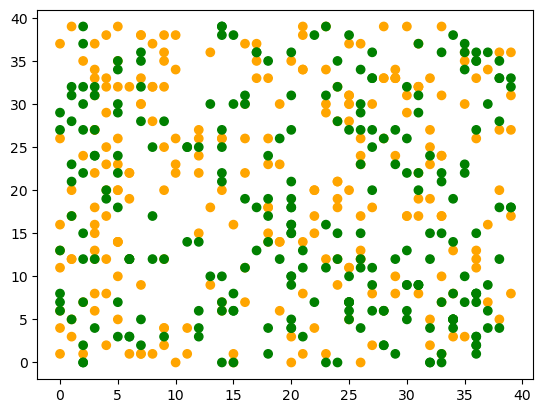

Mean homogeneity:  0.5076305220883535 % 

Iteration  4  : 

Percent of happy agents:  7.228915662650603 % 



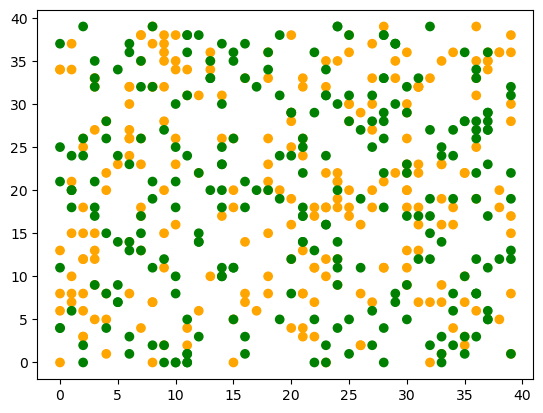

Mean homogeneity:  0.5170682730923695 % 

Iteration  5  : 

Percent of happy agents:  9.236947791164658 % 



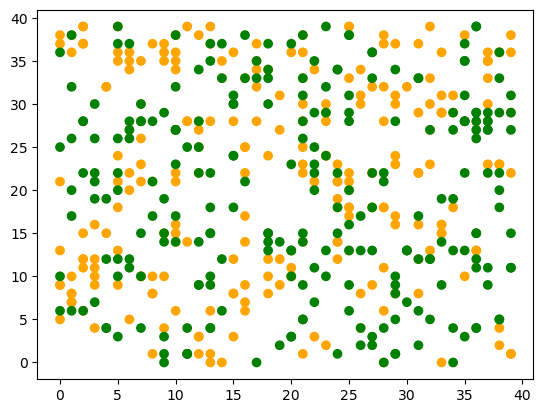

Mean homogeneity:  0.5487951807228916 % 

Iteration  6  : 

Percent of happy agents:  17.068273092369477 % 



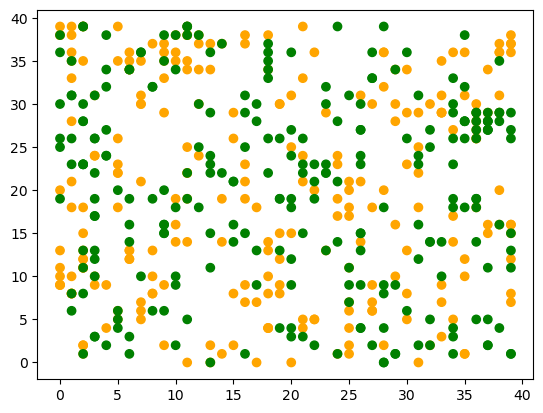

Mean homogeneity:  0.5206827309236948 % 

Iteration  7  : 

Percent of happy agents:  9.63855421686747 % 



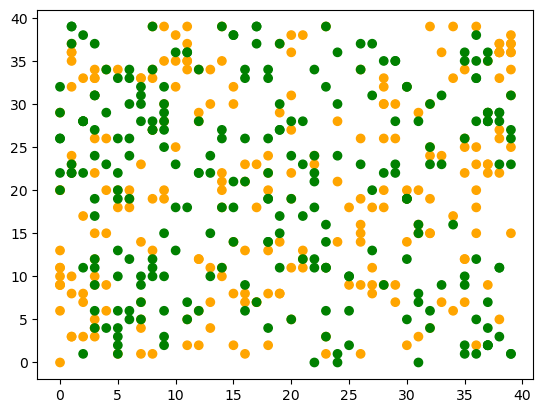

Mean homogeneity:  0.5443775100401607 % 

Iteration  8  : 

Percent of happy agents:  15.060240963855422 % 



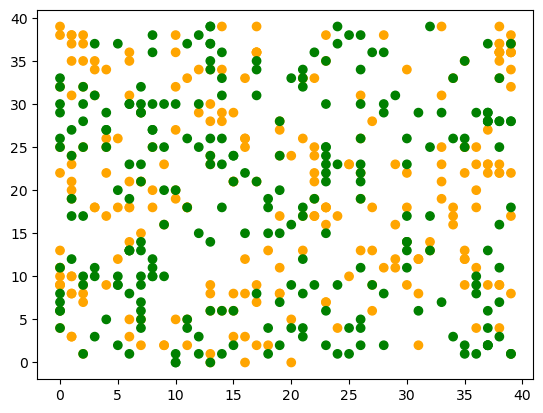

Mean homogeneity:  0.5694779116465863 % 

Iteration  9  : 

Percent of happy agents:  21.08433734939759 % 



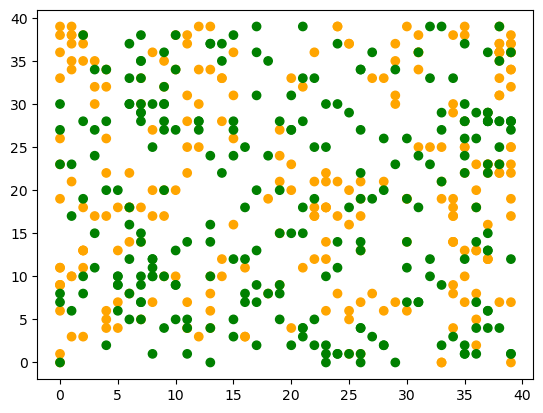

Mean homogeneity:  0.5660642570281125 % 

Iteration  10  : 

Percent of happy agents:  23.29317269076305 % 



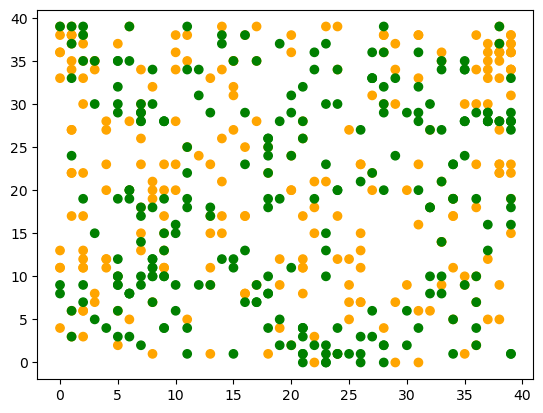

In [78]:
vec = setupAndRunSim(10, 0.80, 10, 249, 249, True)

In [12]:
for j in range(100):
    tolerance = uniform(0, 1)
    vec = setupAndRunSimFullOutput(10, tolerance, 10, 250, 250, False)
    df_inputs = pd.DataFrame([vec])
    df_outputs = pd.DataFrame([tolerance])
    for i in range(99):
        tolerance = uniform(0, 1)
        vec = setupAndRunSimFullOutput(10, tolerance, 10, 250, 250, False)
        df_inputs.loc[len(df_inputs.index)] =  vec
        df_outputs.loc[len(df_outputs.index)] =  tolerance
    input_file_name = "train_inputs_" + str(j) + ".csv"
    output_file_name = "train_outputs_" + str(j) + ".csv"
    df_inputs.to_csv(input_file_name, encoding='utf-8', index=False)
    df_outputs.to_csv(output_file_name, encoding='utf-8', index=False)

KeyboardInterrupt: 

In [ ]:
from multiprocessing import Pool

def generateSims(j):
    tolerance = uniform(0, 1)
    vec_hap, vec_homo = setupAndRunSim(10, tolerance, 10, 250, 250, False)
    df_inputs = pd.DataFrame([vec_hap])
    df_inputs2 = pd.DataFrame([vec_homo])
    df_outputs = pd.DataFrame([tolerance])
    for i in range(99):
        tolerance = uniform(0, 1)
        vec_hap, vec_homo = setupAndRunSim(10, tolerance, 10, 250, 250, False)
        df_inputs.loc[len(df_inputs.index)] =  vec_hap
        df_inputs2.loc[len(df_inputs2.index)] =  vec_homo
        df_outputs.loc[len(df_outputs.index)] =  tolerance
    input_file_name = "train_inputs_hap_" + str(j) + ".csv"
    input2_file_name = "train_inputs_homo_" + str(j) + ".csv"
    output_file_name = "train_outputs_hap_" + str(j) + ".csv"
    df_inputs.to_csv(input_file_name, encoding='utf-8', index=False)
    df_inputs2.to_csv(input2_file_name, encoding='utf-8', index=False)
    df_outputs.to_csv(output_file_name, encoding='utf-8', index=False)
    
def run_generate_sims(operation, input, pool):
    pool.map(operation, input)
    
if __name__ == '__main__':
    processes_count = 20
    processes_pool = Pool(processes_count)
    run_generate_sims(generateSims, range(100), processes_pool)   

In [93]:
import os
print('Number of CPUs in the system: {}'.format(os.cpu_count()))

Number of CPUs in the system: 8
